# Large-Scale Wasserstein Gradient Flows

In [1]:
import yaml
from src.experiments.exp_file_manager import OU_vary_dim_EFM, OU_fixed_dim_EFM
from src.experiments.exp_file_manager import Filtering_EFM, ConvergenceComparison_EFM
from src.experiments.exp_file_manager import Convergence_EFM, DataPosterior_EFM
from collections import defaultdict
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# basic font setting
font = {'size'  : 16}
import matplotlib
matplotlib.rc('font', **font)

## Ornstein-Uhlenbeck

**Helpful functions**

In [2]:
def make_ou_EFM(method):
    config_path = f'./configs/ornstein_uhlenbeck_vary_dim.yml'
    data_path = f'./results/ou_vary_dim'
    return OU_vary_dim_EFM.fromconfigpath(config_path, method, data_path)

def get_mean_med_int(arr, transform=np.log10, alpha=0.95):
    arr = transform(arr)
    arr = arr[~np.isnan(arr)]
    _mean = np.mean(arr)
    _med = np.median(arr)
    S = np.sqrt(np.mean(arr**2) - _mean**2)
    z = sps.norm.ppf((1. + alpha)/2.)
    _int = z * S / np.sqrt(len(arr))
    return _mean, _med, _int
    
def get_kl_sym_stats_ou(dim_range, method, n_step, transform=np.log10):
    conv_stats = {
        'means': defaultdict(list),
        'meds': defaultdict(list),
        'ints': defaultdict(list)
    }
    efm = make_ou_EFM(method)
    for dim in dim_range:
        kl_sym = efm.loc('kl_sym', dim, n_step)
        _mean, _med, _int = get_mean_med_int(kl_sym, transform=transform)
        conv_stats['means']['kl_sym'].append(_mean)
        conv_stats['meds']['kl_sym'].append(_med)
        conv_stats['ints']['kl_sym'].append(_int)
    return conv_stats

def draw_stats(stats, ax, color, label, measure, legend_position='best', legend_ncol=1):
    ax.plot(dims, stats['meds'][measure], color=color, label=label)
    _means = np.asarray(stats['means'][measure])
    _ints = np.asarray(stats['ints'][measure])
    ax.fill_between(
        dims, 
        (_means - _ints), 
        (_means + _ints), color=color, alpha=.1)
    ax.legend(loc=legend_position, ncol=legend_ncol)

**Results demonstration**

In [7]:
dims = list(range(1, 13))
methods = ['dual_jko', 'EM_sim_1000', 'EM_sim_10000', 'EM_sim_50000', 'EM_ProxRec_10000', 'ICNN_jko']
names = ['[Dual JKO]', '[EM] 1K', '[EM] 10K', '[EM] 50K', '[EM PR] 10K', 'Ours']
colors = ['magenta', 'blue', 'green', 'gold', 'lawngreen', 'darkturquoise']

def draw_em_results(time_moment, savefig=True, prohibit_drawing=False):
    index = round(10 * (time_moment - 0.1))
    fig, ax = plt.subplots(figsize=(8, 5.7), dpi=80)
    # ax.set_title(r'Discrepancy at $t = 0.5$ sec.', fontsize=18)
    ax.set_xlabel('D, dimension', fontsize=18)
    ax.set_ylabel(r'$\log_{10}$SymKL', fontsize=18)
    est_stat = 'kl_sym'
    for method, name, color in zip(methods, names, colors):
        draw_stats(get_kl_sym_stats_ou(dims, method, index), ax, color, name, est_stat, legend_position='best', legend_ncol=2)
    plt.grid(which='major')
    plt.minorticks_on()
    plt.tight_layout()
    if not prohibit_drawing:
        plt.show()
    else:
        plt.close()
    if savefig:
        file_name = f'ou_sym_kl_{int(time_moment)}_{round(time_moment * 10) % 10}'
        fig.savefig(f"images/{file_name}.pdf", bbox_inches='tight', dpi=200)
        fig.savefig(f"images/{file_name}.png", bbox_inches='tight', dpi=200)

**Comparison at $t = 0.5$ sec.**  

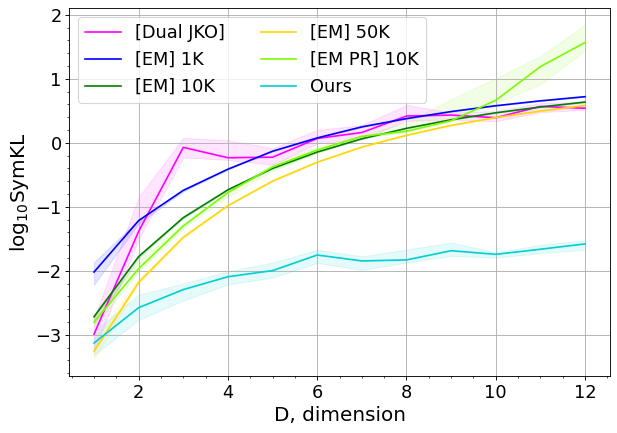

In [4]:
draw_em_results(0.5, savefig=False)

**Comparison at $t = 0.9$ sec.**

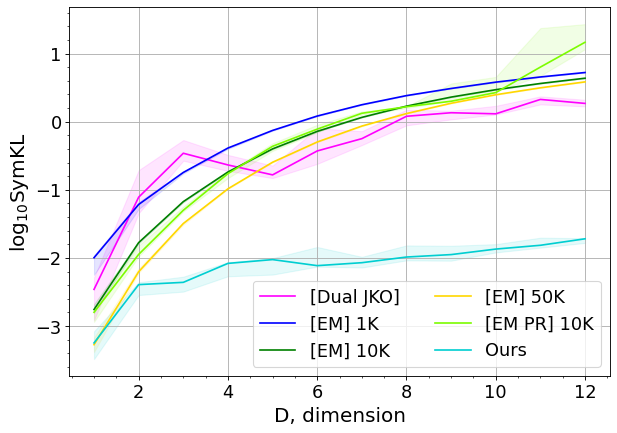

In [5]:
draw_em_results(0.9, savefig=False)

**Saving comparisons at $t \in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]$ sec. time moments**

In [8]:
for t in np.linspace(0.1, 1., 10):
    draw_em_results(t, savefig=True, prohibit_drawing=True)

## Nonlinear filtering

**Helpful functions**

In [9]:
def make_filtering_EFM(method):
    config_path = f'./configs/filtering.yml'
    data_path = f'./results/filtering'
    return Filtering_EFM.fromconfigpath(config_path, method, data_path)

def get_filtering_final_distribs(n_exp):
    dummy_method = 'bbf_1000'
    efm = make_filtering_EFM(dummy_method)
    methods = ['ICNN_jko', 'dual_jko', 'bbf_50000', 'ChangCooper']
    final_distribs = {method: efm.load_np(n_exp, method) for method in methods}
    return final_distribs

**Results demonstration**

In [10]:
filt_icnn_jko = make_filtering_EFM('ICNN_jko').loc('kl_sym')
filt_bbf_1000 = make_filtering_EFM('bbf_1000').loc('kl_sym')
filt_bbf_10000 = make_filtering_EFM('bbf_10000').loc('kl_sym')
filt_bbf_50000 = make_filtering_EFM('bbf_50000').loc('kl_sym')
filt_bbf_100 = make_filtering_EFM('bbf_100').loc('kl_sym')
filt_dual_jko = make_filtering_EFM('dual_jko').loc('kl_sym')

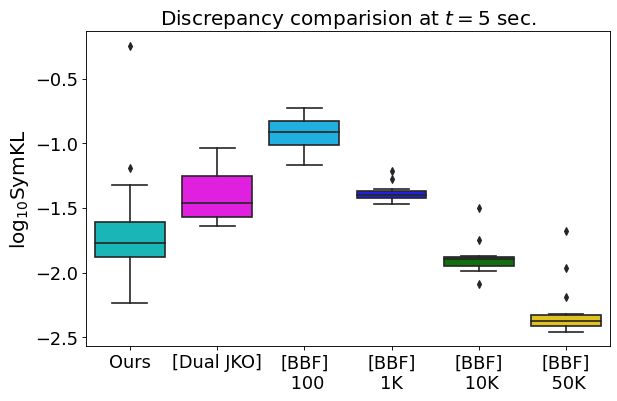

In [11]:
df = pd.DataFrame({
    'Ours': np.log10(filt_icnn_jko),
    '[Dual JKO]': np.log10(filt_dual_jko),
    '[BBF]\n 100': np.log10(filt_bbf_100),
    '[BBF]\n1K': np.log10(filt_bbf_1000),
    '[BBF]\n 10K': np.log10(filt_bbf_10000),
    '[BBF]\n 50K': np.log10(filt_bbf_50000)})
palette = {
    "Ours": 'darkturquoise', 
    '[Dual JKO]': 'magenta',
    '[BBF]\n 100': 'deepskyblue',
    "[BBF]\n1K": "blue", 
    '[BBF]\n 10K': 'green', 
    '[BBF]\n 50K': 'gold'}

fig, ax = plt.subplots(figsize=(8, 5), dpi=80)

sns.boxplot(data=df, ax=ax, palette=palette)
# ax.set_ylim(-2.5, -0.75)
plt.ylabel(r'$\log_{10}$SymKL', fontsize=18)
# plt.xlabel('method', fontsize=16)
plt.tight_layout()
plt.title('Discrepancy comparision at $t=5$ sec.', fontsize=18)
plt.show()
fig.savefig("./images/filtering_boxplot.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/filtering_boxplot.png", bbox_inches='tight', dpi=200)

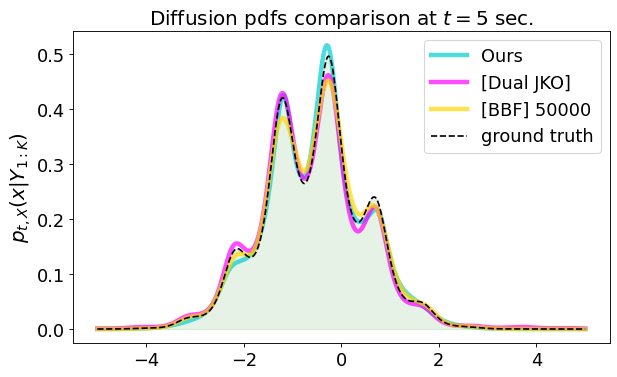

In [12]:
n_exp = 12
final_distribs = get_filtering_final_distribs(n_exp)

fig, ax = plt.subplots(figsize=(8, 5), dpi=80)

labels = {
    "ICNN_jko": 'Ours',
    "dual_jko": "[Dual JKO]", 
    'bbf_50000': '[BBF] 50000'}
palette = {
    "ICNN_jko": 'darkturquoise',
    "dual_jko": "magenta", 
    'bbf_50000': 'gold'}

for method, distrib in final_distribs.items():
    if method == 'ChangCooper':
        pass
    else:
        ax.plot(distrib[0], distrib[1], label=labels[method], color=palette[method], linewidth=4., alpha=0.7)
if 'ChangCooper' in final_distribs.keys():
    ax.plot(distrib[0], distrib[1], '--', color='black', label='ground truth')
    ax.fill_between(distrib[0], distrib[1], color='green', alpha=0.1)
plt.title(f'Diffusion pdfs comparison at $t=5$ sec.', fontsize=18)
plt.ylabel(r'$p_{t,X}(x|Y_{1:K})$', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("./images/filtering_pdf_comparison.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/filtering_pdf_comparison.png", bbox_inches='tight', dpi=200)

## Convergence to stationary distribution

### Convergence visualization

#### `Dim=13` convergence visualization

In [13]:
def make_convergence_EFM(dim):
    config_path = f'./configs/convergence_mix_gauss_dim_{dim}.yml'
    data_path = f'./results/convergence_dim_{dim}'
    return Convergence_EFM.fromconfigpath(config_path, data_path)

device='cuda:0'

In [14]:
# efm = Convergence_EFM(path, config)
efm = make_convergence_EFM(13)
model = efm.load_model(map_location=device)
stat_distrib = model.target_distrib

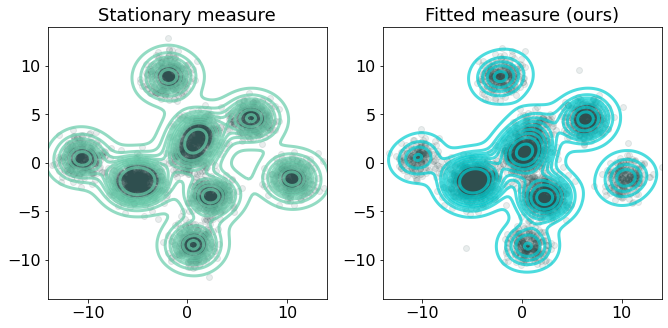

In [15]:
X_targ = stat_distrib.sample((4000,)).cpu().numpy()
X_trf_arr = model.sample(4000).cpu().numpy()
pca = PCA(n_components=2)
X_targ_pca = pca.fit_transform(X_targ)
X_trf_pca = pca.transform(X_trf_arr)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

sns.kdeplot(x = X_targ_pca[:, 0], y = X_targ_pca[:, 1], ax=ax[0], color='mediumaquamarine', linewidths=3.0, levels=10, alpha=0.7)
xlims = (-14, 14)
ylims= (-14, 14)
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
ax[0].set_title('Stationary measure', fontsize=18)
ax[0].scatter(X_targ_pca[:, 0], X_targ_pca[:, 1], color='darkslategray', alpha=0.1)

sns.kdeplot(x = X_trf_pca[:, 0], y = X_trf_pca[:, 1], ax = ax[1], color='darkturquoise', linewidths=3.0, levels=10, alpha=0.7)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].set_title('Fitted measure (ours)', fontsize=18)
ax[1].scatter(X_trf_pca[:, 0], X_trf_pca[:, 1], color='darkslategray', alpha=0.1,)
# plt.tight_layout()
plt.show()
fig.savefig("./images/convergence_mix_gauss_13.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/convergence_mix_gauss_13.png", bbox_inches='tight', dpi=200)

#### `Dim=32` convergence visualization

In [16]:
# efm = Convergence_EFM(path, config)
efm = make_convergence_EFM(32)
model = efm.load_model(map_location=device)
stat_distrib = model.target_distrib

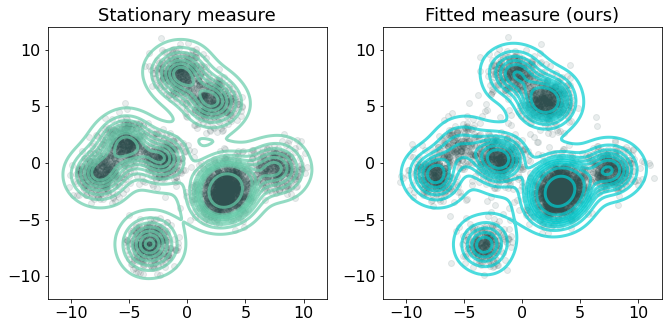

In [17]:
X_targ = stat_distrib.sample((4000,)).cpu().numpy()
X_trf_arr = model.sample(4000).cpu().numpy()
pca = PCA(n_components=2)
X_targ_pca = pca.fit_transform(X_targ)
X_trf_pca = pca.transform(X_trf_arr)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

sns.kdeplot(x = X_targ_pca[:, 0], y = X_targ_pca[:, 1], ax=ax[0], color='mediumaquamarine', linewidths=3.0, levels=10, alpha=0.7)
xlims = (-12, 12)
ylims= (-12, 12)
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
ax[0].set_title('Stationary measure', fontsize=18)
ax[0].scatter(X_targ_pca[:, 0], X_targ_pca[:, 1], color='darkslategray', alpha=0.1)

sns.kdeplot(x = X_trf_pca[:, 0], y = X_trf_pca[:, 1], ax = ax[1], color='darkturquoise', linewidths=3.0, levels=10, alpha=0.7)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].set_title('Fitted measure (ours)', fontsize=18)
ax[1].scatter(X_trf_pca[:, 0], X_trf_pca[:, 1], color='darkslategray', alpha=0.1,)
# plt.tight_layout()
plt.show()
fig.savefig("./images/convergence_mix_gauss_32.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/convergence_mix_gauss_32.png", bbox_inches='tight', dpi=200)

### Convergence comparison

**Helpful functions**

In [12]:
def make_conv_comp_EFM(dim, method):
    config_path = f'./configs/convergence_comparison_dim_{dim}.yml'
    data_path = f'./results/conv_comp_dim_{dim}'
    return ConvergenceComparison_EFM.fromconfigpath(config_path, method, data_path)

def get_kl_sym_stats_conv_comp(dim_range, method, transform=np.log10):
    conv_stats = {
        'means': defaultdict(list),
        'meds': defaultdict(list),
        'ints': defaultdict(list)
    }
    for dim in dim_range:
        efm = make_conv_comp_EFM(dim, method)
        kl_sym = efm.loc('kl_sym')
        _mean, _med, _int = get_mean_med_int(kl_sym, transform=transform)
        conv_stats['means']['kl_sym'].append(_mean)
        conv_stats['meds']['kl_sym'].append(_med)
        conv_stats['ints']['kl_sym'].append(_int)
    return conv_stats

**Results demonstration**

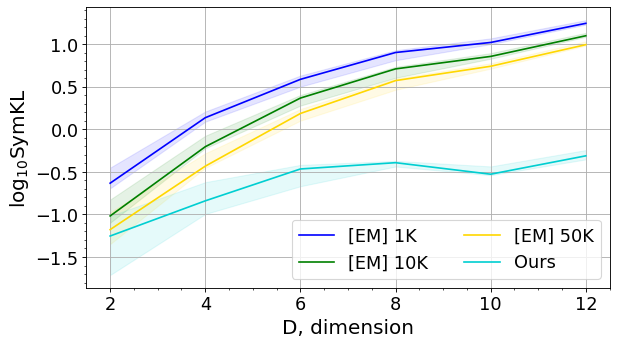

In [14]:
dims = [2, 4, 6, 8, 10, 12]
methods = ['EM_sim_1000', 'EM_sim_10000', 'EM_sim_50000', 'ICNN_jko']
names = ['[EM] 1K', '[EM] 10K', '[EM] 50K', 'Ours']
colors = ['blue', 'green', 'gold', 'darkturquoise']

fig, ax = plt.subplots(figsize=(8, 4.6), dpi=80)
# ax.set_title(r'Discrepancy at $t = 0.9$ sec.', fontsize=18)
ax.set_xlabel('D, dimension', fontsize=18)
ax.set_ylabel(r'$\log_{10}$SymKL', fontsize=18)
est_stat = 'kl_sym'
for method, name, color in zip(methods, names, colors):
    draw_stats(get_kl_sym_stats_conv_comp(dims, method), ax, color, name, est_stat, legend_position='lower right', legend_ncol=2)
plt.grid(which='major')
plt.minorticks_on()
plt.tight_layout()
plt.show()
fig.savefig("./images/convergence_comparison.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/convergence_comparison.png", bbox_inches='tight', dpi=200)

**Results demonstration with additional ``EM PR`` particle method**

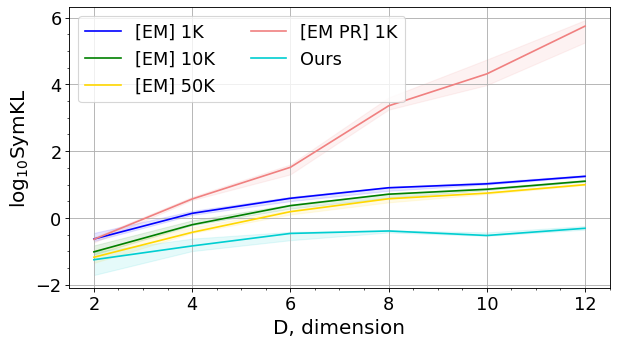

In [17]:
dims = [2, 4, 6, 8, 10, 12]
methods = ['EM_sim_1000', 'EM_sim_10000', 'EM_sim_50000', 'EM_ProxRec_1000', 'ICNN_jko']
names = ['[EM] 1K', '[EM] 10K', '[EM] 50K', '[EM PR] 1K', 'Ours']
colors = ['blue', 'green', 'gold', 'lightcoral', 'darkturquoise']

fig, ax = plt.subplots(figsize=(8, 4.6), dpi=80)
# ax.set_title(r'Discrepancy at $t = 0.9$ sec.', fontsize=18)
ax.set_xlabel('D, dimension', fontsize=18)
ax.set_ylabel(r'$\log_{10}$SymKL', fontsize=18)
est_stat = 'kl_sym'
for method, name, color in zip(methods, names, colors):
    draw_stats(get_kl_sym_stats_conv_comp(dims, method), ax, color, name, est_stat, legend_position='best', legend_ncol=2)
plt.grid(which='major')
plt.minorticks_on()
plt.tight_layout()
plt.show()
fig.savefig("./images/convergence_comparison_em_pr.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/convergence_comparison_em_pr.png", bbox_inches='tight', dpi=200)

## Posterior Sampling

In [21]:
def make_post_samp_EFM(dataset):
    config_path = f'./configs/{dataset}_data_posterior.yml'
    data_path = f'./results/data_posterior'
    return DataPosterior_EFM.fromconfigpath(config_path, data_path)

In [22]:
ds_names = ['covtype', 'german', 'diabetis', 'twonorm', 
        'ringnorm', 'banana', 'splice', 'waveform', 'image'] 
accs = [make_post_samp_EFM(_name).loc('accuracy') for _name in ds_names]
log_liks = [make_post_samp_EFM(_name).loc('log_lik') for _name in ds_names]

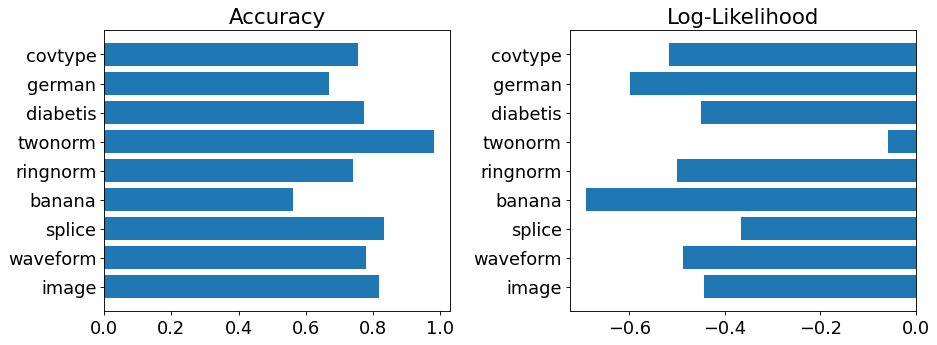

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4.6), dpi=80)

ax = axs[0]
y_pos = np.arange(len(ds_names))
ax.barh(y_pos, accs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ds_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Accuracy')

ax = axs[1]
ax.barh(y_pos, log_liks, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ds_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Log-Likelihood')
plt.tight_layout()
plt.show()
fig.savefig("./images/post_sampling.pdf", bbox_inches='tight', dpi=200)
fig.savefig("./images/post_sampling.png", bbox_inches='tight', dpi=200)